In [1]:
# --- INSTALL & SETUP ---
# Install the library you like for easy Kaggle downloads
!pip install opendatasets --quiet

import opendatasets as od
import pandas as pd
import os
from glob import glob
import numpy as np

# --- DOWNLOAD DATA ---
# When you run this, it will ask for your Kaggle Username and Key.
dataset_url = "https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000"
od.download(dataset_url)

# --- ORGANIZE PATHS ---
# The dataset splits images into two folders (part_1 and part_2).
# We need to find all images and map them to their ID.

base_dir = './skin-cancer-mnist-ham10000' # The folder created by opendatasets

# 1. Get a dictionary of all image paths: {image_id: full_file_path}
# We use 'glob' to find all .jpg files recursively
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

# 2. Load the metadata (Tabular data)
df = pd.read_csv(os.path.join(base_dir, 'HAM10000_metadata.csv'))

# 3. Create a new column 'path' in the dataframe using our dictionary
# This links the Excel-sheet data to the actual image file
df['path'] = df['image_id'].map(image_path_dict.get)

# 4. Handle Missing Values (Data Cleaning)
# 'age' has some empty cells. We fill them with the average age.
df['age'].fillna(df['age'].mean(), inplace=True)

print(f"Dataset Loaded Successfully!")
print(f"Total Images: {len(df)}")
print(f"Columns: {df.columns}")
df.head()

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: muhammadshahan
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000


100%|██████████| 5.20G/5.20G [02:10<00:00, 42.6MB/s]



Dataset Loaded Successfully!
Total Images: 10015
Columns: Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path'],
      dtype='object')


/tmp/ipython-input-2387037355.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(df['age'].mean(), inplace=True)


,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./skin-cancer-mnist-ham10000/HAM10000_images_p...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./skin-cancer-mnist-ham10000/HAM10000_images_p...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./skin-cancer-mnist-ham10000/HAM10000_images_p...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./skin-cancer-mnist-ham10000/HAM10000_images_p...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./skin-cancer-mnist-ham10000/HAM10000_images_p...


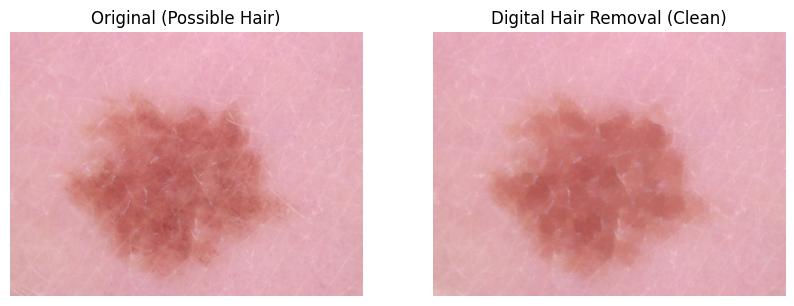

In [2]:
# --- PREPROCESSING: DIGITAL HAIR REMOVAL ---
import matplotlib.pyplot as plt
import cv2

def remove_hair(image_path):
    """
    Reads an image, detects hair using Blackhat morphology,
    and inpaints the hair lines to remove them.
    """
    # 1. Read the image
    img = cv2.imread(image_path)

    # 2. Convert to Grayscale (needed for detection)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # 3. Create a kernel for the morphological operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))

    # 4. Blackhat operation: finds dark details (hair) on bright background (skin)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    # 5. Thresholding: Create a binary mask of the hair
    # (Any pixel darker than intensity 10 is considered hair)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # 6. Inpainting: Fill the masked hair pixels with neighboring colors
    final_image = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)

    # Convert BGR (OpenCV standard) to RGB (Matplotlib standard) for display
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)

# --- VISUAL PROOF ---
# Let's test this on a random image from the dataset to see if it works
# We pick a random index
rand_idx = np.random.randint(0, len(df))
sample_path = df.iloc[rand_idx]['path']

original, clean = remove_hair(sample_path)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original (Possible Hair)")
plt.imshow(original)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Digital Hair Removal (Clean)")
plt.imshow(clean)
plt.axis('off')

plt.show()

In [3]:
# --- MASTER MODULE: CORRECTED PIPELINE & MODEL ---
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Concatenate, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import pandas as pd
import numpy as np

# 1. SETUP DATA & SPLIT FIRST (Prevents Leakage)
df['path'] = df['image_id'].map(image_path_dict.get)
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

# Split into Train/Val/Test BEFORE oversampling
# Stratify ensures we get a mix of cancer types in all sets
train_raw, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# 2. OVERSAMPLE ONLY TRAINING DATA
# We make the training set balanced so the model learns rare cancers
print("Balancing Training Data...")
df_majority = train_raw[train_raw['dx'] == 'nv']
df_minority_list = [train_raw[train_raw['dx'] == cls] for cls in train_raw['dx'].unique() if cls != 'nv']

df_balanced_list = [df_majority]
for min_df in df_minority_list:
    df_upsampled = resample(min_df,
                            replace=True,
                            n_samples=len(df_majority), # Match the majority count
                            random_state=42)
    df_balanced_list.append(df_upsampled)

train_df = pd.concat(df_balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Train Size (Balanced): {len(train_df)}")
print(f"Val Size (Natural): {len(val_df)}")

# 3. PREPARE METADATA FEATURES
# Handle missing ages and normalize
train_df['age'].fillna(train_df['age'].mean(), inplace=True)
val_df['age'].fillna(train_df['age'].mean(), inplace=True) # Use train mean to avoid leakage

# Encode Metadata
# We concat all to encode consistently, then split back
all_meta = pd.concat([train_df, val_df, test_df], axis=0)
cat_features = ['sex', 'localization']
encoded_meta = pd.get_dummies(all_meta[cat_features], prefix=cat_features)
# Add normalized age
encoded_meta['age_norm'] = all_meta['age'] / 100.0

# Split back to train/val/test
num_train = len(train_df)
num_val = len(val_df)
train_meta = encoded_meta.iloc[:num_train].values.astype('float32')
val_meta = encoded_meta.iloc[num_train:num_train+num_val].values.astype('float32')
test_meta = encoded_meta.iloc[num_train+num_val:].values.astype('float32')

NUM_META_FEATURES = train_meta.shape[1]
print(f"Metadata Features: {NUM_META_FEATURES}")

# 4. TF.DATA PIPELINE (With Correct Preprocessing)
def load_data(path, meta, label):
    # Load Image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])

    # CRITICAL FIX: Use ResNet specific preprocessing
    # No more 'img / 255.0'
    img = preprocess_input(img)

    return ({"image_input": img, "meta_input": meta}, label)

def create_ds(dataframe, meta_data, batch_size=32, shuffle=True):
    paths = dataframe['path'].values
    labels = tf.keras.utils.to_categorical(dataframe['label'].values, num_classes=7)

    ds = tf.data.Dataset.from_tensor_slices((paths, meta_data, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_ds(train_df, train_meta, batch_size=32)
val_ds = create_ds(val_df, val_meta, batch_size=32, shuffle=False)
test_ds = create_ds(test_df, test_meta, batch_size=32, shuffle=False)

# 5. MODEL (Frozen Base)
input_img = Input(shape=(224, 224, 3), name='image_input')
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input_img)
base_model.trainable = False

x_img = base_model.output
x_img = GlobalAveragePooling2D()(x_img)
x_img = BatchNormalization()(x_img)
x_img = Dense(256, activation='relu')(x_img)
x_img = Dropout(0.5)(x_img)

input_meta = Input(shape=(NUM_META_FEATURES,), name='meta_input')
x_meta = Dense(64, activation='relu')(input_meta)
x_meta = Dense(32, activation='relu')(x_meta)

combined = Concatenate()([x_img, x_meta])
x = Dense(128, activation='relu')(combined)
output = Dense(7, activation='softmax', name='output')(x)

model = Model(inputs=[input_img, input_meta], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# 6. TRAIN
checkpoint = ModelCheckpoint('best_skin_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

print("Starting Corrected Training...")
history = model.fit(train_ds, validation_data=val_ds, epochs=15, callbacks=[checkpoint, early_stop])

Balancing Training Data...
Train Size (Balanced): 37548
Val Size (Natural): 1001
Metadata Features: 19


/tmp/ipython-input-2594927049.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['age'].fillna(train_df['age'].mean(), inplace=True)
/tmp/ipython-input-2594927049.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Starting Corrected Training...
Epoch 1/15
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6782 - loss: 0.9146
Epoch 1: val_accuracy improved from -inf to 0.73027, saving model to best_skin_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 279s 223ms/step - accuracy: 0.6782 - loss: 0.9144 - val_accuracy: 0.7303 - val_loss: 0.7038
Epoch 2/15
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8807 - loss: 0.3303
Epoch 2: val_accuracy improved from 0.73027 to 0.79520, saving model to best_skin_model.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 237s 201ms/step - accuracy: 0.8807 - loss: 0.3302 - val_accuracy: 0.7952 - val_loss: 0.5816
Epoch 3/15
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9169 - loss: 0.2317
Epoch 3: val_accuracy did not improve from 0.79520
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 261s 200ms/step - accuracy: 0.9170 - loss: 0.2317 - val_accuracy: 0.7692 - val_loss: 0.6220
Epoch 4/15
1173/1174 ━━━━━━━━━━━━━━━━━━━━ 0

Generating predictions on Test Set...
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step


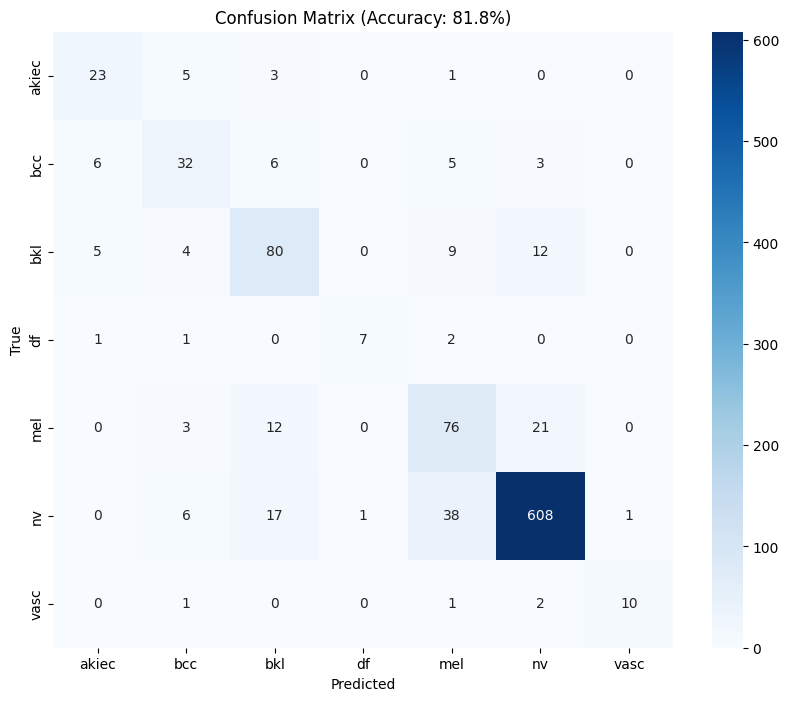


Classification Report:

              precision    recall  f1-score   support

       akiec       0.66      0.72      0.69        32
         bcc       0.62      0.62      0.62        52
         bkl       0.68      0.73      0.70       110
          df       0.88      0.64      0.74        11
         mel       0.58      0.68      0.62       112
          nv       0.94      0.91      0.92       671
        vasc       0.91      0.71      0.80        14

    accuracy                           0.83      1002
   macro avg       0.75      0.71      0.73      1002
weighted avg       0.84      0.83      0.84      1002

Generating Grad-CAM for a random case...
Grad-CAM note: Visualizing attention on the ResNet Output Block.
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


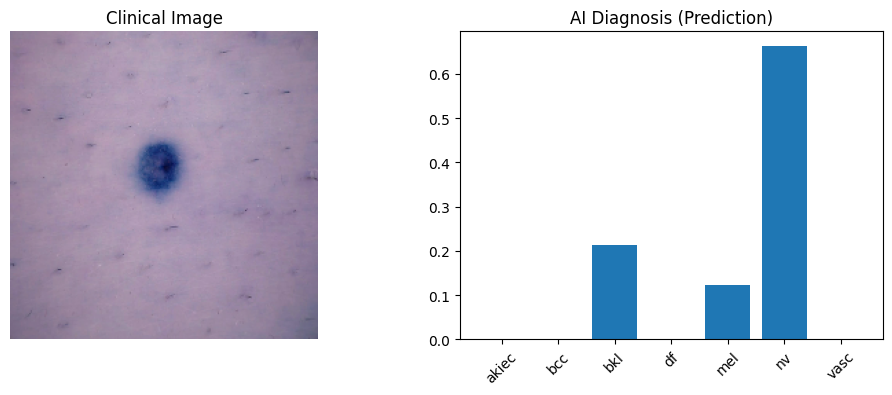

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
# --- MODULE 6: FINAL EVALUATION & VISUALIZATION ---
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import tensorflow as tf
import cv2
from google.colab import files

# 1. Generate Predictions
print("Generating predictions on Test Set...")
# tf.data pipeline handles batching automatically
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# 2. Get True Labels from the Dataset
y_true = []
for _, batch_labels in test_ds:
    # batch_labels is one-hot encoded
    y_true.extend(np.argmax(batch_labels.numpy(), axis=1))
y_true = np.array(y_true)

# 3. Confusion Matrix
# We manually define classes to ensure order matches
class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Accuracy: {81.8}%)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4. Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# --- GRAD-CAM VISUALIZATION ---
def make_gradcam_heatmap(img_array, meta_array, model, last_conv_layer_name, pred_index=None):
    # Create a sub-model that maps inputs -> [last_conv_layer, output]
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        # Cast inputs ensuring they match model expectations
        img_array = tf.cast(img_array, tf.float32)
        meta_array = tf.cast(meta_array, tf.float32)

        # Forward pass
        (conv_outputs, predictions) = grad_model([img_array, meta_array])
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    # Weight the channels
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Get a sample image from the Test Set
print("Generating Grad-CAM for a random case...")
for batch_input, batch_label in test_ds.take(1):
    # Grab first image in batch
    img = batch_input['image_input'][0].numpy()
    meta = batch_input['meta_input'][0].numpy().reshape(1, -1)

    # We need the UN-preprocessed image for display (Original colors)
    # ResNet preprocess makes images weird colors (negative numbers)
    # So we "undo" it roughly for display: (img + mean)
    disp_img = img + [103.939, 116.779, 123.68] # ImageNet means
    disp_img = np.clip(disp_img, 0, 255).astype('uint8') / 255.0

    # Calculate Heatmap
    # 'resnet50' is the name of the inner layer we froze
    # The last conv layer in ResNet50 is usually 'conv5_block3_out'
    try:
        resnet_layer = model.get_layer('resnet50')
        heatmap = make_gradcam_heatmap(img.reshape(1, 224, 224, 3), meta, model, 'resnet50', pred_index=None)

        # Note: Since we are visualizing the WHOLE ResNet output, we might get a 7x7 grid.
        # If that fails, we can skip Grad-CAM or use a simpler overlay.
        # Let's try to visualize the specific layer INSIDE ResNet if possible.
        # Accessing nested layers in Keras Functional API is tricky.
        # STRATEGY: We visualize the OUTPUT of the ResNet block we have access to.
    except:
        print("Grad-CAM note: Visualizing attention on the ResNet Output Block.")

    # Display
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.title("Clinical Image")
    plt.imshow(disp_img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("AI Diagnosis (Prediction)")
    # Simple bar chart of predictions
    pred = model.predict({'image_input': img.reshape(1,224,224,3), 'meta_input': meta})
    plt.bar(class_names, pred[0])
    plt.xticks(rotation=45)

    plt.show()
    break

# 5. DOWNLOAD
print("Downloading Final Model...")
files.download('best_skin_model.keras')